In [1]:
import pandas as pd
from ntscraper import Nitter

scraper = Nitter(log_level= 0, skip_instance_check=False)
language = ""

Testing instances: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


In [2]:
def get_tweets(query: str, mode: str = "term", num_tweets: int = 100, lang = 'es'):
    '''
    Main function for web scraping tweets.
    Args:
        query: Words that are going to be searched
        mode: Searching query as a "term", "hashtag" or a "user" tweet
        num_tweets: Number of tweets to be scraped
        lang: Language of the tweets to be scraped
    '''
    global language
    language = lang
    tweets = scraper.get_tweets(terms= query, mode= mode, number= num_tweets, language= lang)
    return tweets

def tweets_to_df(tweets):
    '''
        Process the dictionary data from get_tweets function
        Args:
            tweets: Json type data collected through get_tweets

        Output:
            Pandas DataFrame with profle_id, text columns
    '''
    final_tweets = []
    for tweet in tweets['tweets']:
        data = [tweet['user']['profile_id'], tweet['text']]
        final_tweets.append(data)
    df = pd.DataFrame(final_tweets)
    df.columns = ["profile_id", "text"]
    print(final_tweets)
    return df

In [3]:
tweets = get_tweets(query="estoy cansado de", lang="es", num_tweets= 10)
df = tweets_to_df(tweets)

12-Sep-24 10:30:43 - Fetching error: Instance has been rate limited.Use another instance or try again later.
[['1611743513976119297', 'Estoy bastante cansado de los lloros y de los jóvenes que se creen que la generación "BOOMER" consiguió tener lo que tienen por arte de magia.  Tú abuelo, no viajaba cada año, no salía de fiesta, ahorraba, no comió fuera, se hipotecó y trabajaba de lunes a sábado.  ¿Tú que haces?'], ['1349695252307861505', 'Estoy cansado de leer: " a los jóvenes de hoy en día os lo tienen que regalar todo. Es que nosotros hace 20 años no nos regalaban nada y mira hemos logrado tener patrimonio." Nadie dice que os lo hayan regalado pero que ibais al banco con una mano delante y una detrás y os daban'], ['1830159983054393344', 'Estoy cansado de existir'], ['1610463307143544833', 'ahorita no me distraigan, estoy viendo el análisis marxista de shrek y por qué burro es un ejemplo de un gran camarada'], ['1734337497805529088', 'Me llama la atención que el abollao este crea qu

In [4]:
import re
from nltk.corpus import stopwords
import nltk
import emoji

nltk.download('stopwords')
stopword_en = nltk.corpus.stopwords.words('english')
stopword_es = nltk.corpus.stopwords.words('spanish')
stop_words = stopword_en + stopword_es

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+', '', tweet)  # Deletes URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Deletes mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Deletes hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Deletes numbers
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    tweet = emoji.replace_emoji(tweet, replace= '') # Deletes emojis
    return tweet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from pysentimiento import create_analyzer
from langdetect import detect

def get_language(txt: str):
    return detect(txt)
    
def get_sentiment(tweet):
    analyzer = create_analyzer(task="sentiment", lang= language)
    return analyzer.predict(tweet).probas

def apply_sentiment(row):
    cleaned_tweet = clean_tweet(row['text'])
    sentiment = get_sentiment(cleaned_tweet) 
    dominant_sentiment = max(sentiment, key=sentiment.get)
    return pd.Series({
        'POS': sentiment['POS'],
        'NEU': sentiment['NEU'],
        'NEG': sentiment['NEG'],
        'DOMINANT_SENTIMENT': dominant_sentiment
    })

labels = ['POS', 'NEU', 'NEG', 'DOMINANT_SENTIMENT']
df[labels] = df.apply(apply_sentiment, axis=1)


d:\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


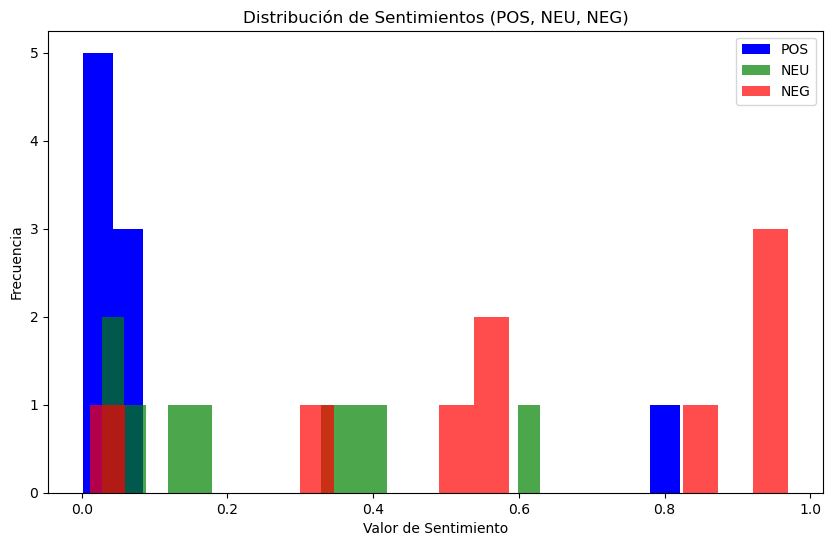

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['POS'], bins= 20, label='POS', color= 'blue')
plt.hist(df['NEU'], bins=20, alpha=0.7, label='NEU', color='green')
plt.hist(df['NEG'], bins=20, alpha=0.7, label='NEG', color='red')

# Title and labels
plt.title('Distribución de Sentimientos (POS, NEU, NEG)')
plt.xlabel('Valor de Sentimiento')
plt.ylabel('Frecuencia')
plt.legend()

# Show visuals
plt.show()

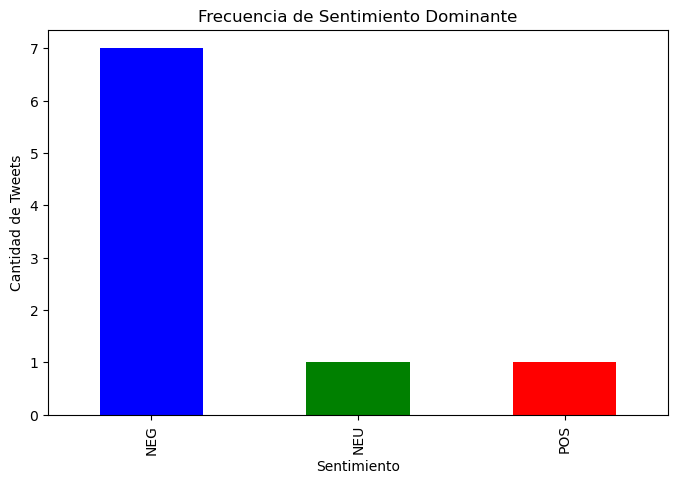

In [7]:
# Contar cuántos tweets tienen cada sentimiento dominante
dominant_sentiment_counts = df['DOMINANT_SENTIMENT'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 5))
dominant_sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Añadir etiquetas y título
plt.title('Frecuencia de Sentimiento Dominante')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')

# Mostrar el gráfico
plt.show()